<a href="https://colab.research.google.com/github/varun-bhaseen/Deep-Learning/blob/master/6-%20Colab%20Notebooks%20Training/MMOE_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation System using MMoE(Multi-gate Mixture-of-Experts)**

**By GPSV Team:**

Gulnara Timokhina,
Mirsaeid Abolghasemi,
Poornapragna Vadiraj,
Varun Bhaseen


**Professor:** Vijay Eranti

**Class:** Advance Deep Learning (CMPE 297 sec 49)

In [ ]:
!pip install transformers

## **Importing libraries needed for the project**

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec
import pandas as pd
import json
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense,Concatenate,ReLU,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score,explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, TFBertModel
from scipy.special import expit
import random

In [ ]:
# Fix random seed for reproducibility
SEED = 1
np.random.seed(SEED)
random.seed(SEED)

## Mounting our Google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Copying the dataset 

Reference: https://www.kaggle.com/

In [ ]:
!cp "/content/drive/MyDrive/DL Project_Recommendation System/Code/videos.csv" ./

In [ ]:
! head -1 videos.csv

,video_id,title,tags,views,likes,dislikes,comment_total,userId,user_click,user_rating,user_like,time_spend,position,pos_bias,device_info,video_emb,user_emb


## Importing TensorBoard

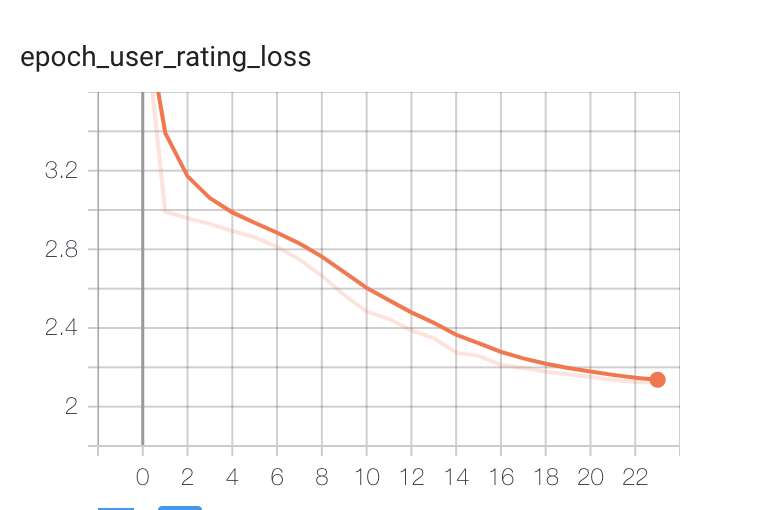

In [ ]:
import os
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir


# Mixture-of-Experts and Network of Gates

Using the Wide & Deep model architecture by adopting Multi-gate Mixture-of-Experts (MMoE) for multitask learning to resolve task conflict.


NOTE: We have used prebuilt model. Reference GitHub Link [here](https://github.com/drawbridge/keras-mmoe/blob/master/mmoe.py)

In [ ]:
class MMoE(Layer):
    """
    Multi-gate Mixture-of-Experts model.
    """

    def __init__(self,
                 units,
                 num_experts,
                 num_tasks,
                 use_expert_bias=True,
                 use_gate_bias=True,
                 expert_activation='relu',
                 gate_activation='softmax',
                 expert_bias_initializer='zeros',
                 gate_bias_initializer='zeros',
                 expert_bias_regularizer=None,
                 gate_bias_regularizer=None,
                 expert_bias_constraint=None,
                 gate_bias_constraint=None,
                 expert_kernel_initializer='VarianceScaling',
                 gate_kernel_initializer='VarianceScaling',
                 expert_kernel_regularizer=None,
                 gate_kernel_regularizer=None,
                 expert_kernel_constraint=None,
                 gate_kernel_constraint=None,
                 activity_regularizer=None,
                 **kwargs):
        """
         Method for instantiating MMoE layer.
        :param units: Number of hidden units
        :param num_experts: Number of experts
        :param num_tasks: Number of tasks
        :param use_expert_bias: Boolean to indicate the usage of bias in the expert weights
        :param use_gate_bias: Boolean to indicate the usage of bias in the gate weights
        :param expert_activation: Activation function of the expert weights
        :param gate_activation: Activation function of the gate weights
        :param expert_bias_initializer: Initializer for the expert bias
        :param gate_bias_initializer: Initializer for the gate bias
        :param expert_bias_regularizer: Regularizer for the expert bias
        :param gate_bias_regularizer: Regularizer for the gate bias
        :param expert_bias_constraint: Constraint for the expert bias
        :param gate_bias_constraint: Constraint for the gate bias
        :param expert_kernel_initializer: Initializer for the expert weights
        :param gate_kernel_initializer: Initializer for the gate weights
        :param expert_kernel_regularizer: Regularizer for the expert weights
        :param gate_kernel_regularizer: Regularizer for the gate weights
        :param expert_kernel_constraint: Constraint for the expert weights
        :param gate_kernel_constraint: Constraint for the gate weights
        :param activity_regularizer: Regularizer for the activity
        :param kwargs: Additional keyword arguments for the Layer class
        """
        # Hidden nodes parameter
        self.units = units
        self.num_experts = num_experts
        self.num_tasks = num_tasks

        # Weight parameter
        self.expert_kernels = None
        self.gate_kernels = None
        self.expert_kernel_initializer = initializers.get(expert_kernel_initializer)
        self.gate_kernel_initializer = initializers.get(gate_kernel_initializer)
        self.expert_kernel_regularizer = regularizers.get(expert_kernel_regularizer)
        self.gate_kernel_regularizer = regularizers.get(gate_kernel_regularizer)
        self.expert_kernel_constraint = constraints.get(expert_kernel_constraint)
        self.gate_kernel_constraint = constraints.get(gate_kernel_constraint)

        # Activation parameter
        self.expert_activation = activations.get(expert_activation)
        self.gate_activation = activations.get(gate_activation)

        # Bias parameter
        self.expert_bias = None
        self.gate_bias = None
        self.use_expert_bias = use_expert_bias
        self.use_gate_bias = use_gate_bias
        self.expert_bias_initializer = initializers.get(expert_bias_initializer)
        self.gate_bias_initializer = initializers.get(gate_bias_initializer)
        self.expert_bias_regularizer = regularizers.get(expert_bias_regularizer)
        self.gate_bias_regularizer = regularizers.get(gate_bias_regularizer)
        self.expert_bias_constraint = constraints.get(expert_bias_constraint)
        self.gate_bias_constraint = constraints.get(gate_bias_constraint)

        # Activity parameter
        self.activity_regularizer = regularizers.get(activity_regularizer)

        # Keras parameter
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

        super(MMoE, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        Method for creating the layer weights.
        :param input_shape: Keras tensor (future input to layer)
                            or list/tuple of Keras tensors to reference
                            for weight shape computations
        """
        assert input_shape is not None and len(input_shape) >= 2

        input_dimension = input_shape[-1]

        # Initialize expert weights (number of input features * number of units per expert * number of experts)
        self.expert_kernels = self.add_weight(
            name='expert_kernel',
            shape=(input_dimension, self.units, self.num_experts),
            initializer=self.expert_kernel_initializer,
            regularizer=self.expert_kernel_regularizer,
            constraint=self.expert_kernel_constraint,
        )

        # Initialize expert bias (number of units per expert * number of experts)
        if self.use_expert_bias:
            self.expert_bias = self.add_weight(
                name='expert_bias',
                shape=(self.units, self.num_experts),
                initializer=self.expert_bias_initializer,
                regularizer=self.expert_bias_regularizer,
                constraint=self.expert_bias_constraint,
            )

        # Initialize gate weights (number of input features * number of experts * number of tasks)
        self.gate_kernels = [self.add_weight(
            name='gate_kernel_task_{}'.format(i),
            shape=(input_dimension, self.num_experts),
            initializer=self.gate_kernel_initializer,
            regularizer=self.gate_kernel_regularizer,
            constraint=self.gate_kernel_constraint
        ) for i in range(self.num_tasks)]

        # Initialize gate bias (number of experts * number of tasks)
        if self.use_gate_bias:
            self.gate_bias = [self.add_weight(
                name='gate_bias_task_{}'.format(i),
                shape=(self.num_experts,),
                initializer=self.gate_bias_initializer,
                regularizer=self.gate_bias_regularizer,
                constraint=self.gate_bias_constraint
            ) for i in range(self.num_tasks)]

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dimension})

        super(MMoE, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """
        Method for the forward function of the layer.
        :param inputs: Input tensor
        :param kwargs: Additional keyword arguments for the base method
        :return: A tensor
        """
        gate_outputs = []
        final_outputs = []

        # f_{i}(x) = activation(W_{i} * x + b), where activation is ReLU according to the paper
        expert_outputs = tf.tensordot(a=inputs, b=self.expert_kernels, axes=1)
        # Add the bias term to the expert weights if necessary
        if self.use_expert_bias:
            expert_outputs = K.bias_add(x=expert_outputs, bias=self.expert_bias)
        expert_outputs = self.expert_activation(expert_outputs)

        # g^{k}(x) = activation(W_{gk} * x + b), where activation is softmax according to the paper
        for index, gate_kernel in enumerate(self.gate_kernels):
            gate_output = K.dot(x=inputs, y=gate_kernel)
            # Add the bias term to the gate weights if necessary
            if self.use_gate_bias:
                gate_output = K.bias_add(x=gate_output, bias=self.gate_bias[index])
            gate_output = self.gate_activation(gate_output)
            gate_outputs.append(gate_output)

        # f^{k}(x) = sum_{i=1}^{n}(g^{k}(x)_{i} * f_{i}(x))
        for gate_output in gate_outputs:
            expanded_gate_output = K.expand_dims(gate_output, axis=1)
            weighted_expert_output = expert_outputs * K.repeat_elements(expanded_gate_output, self.units, axis=1)
            final_outputs.append(K.sum(weighted_expert_output, axis=2))

        return final_outputs

    def compute_output_shape(self, input_shape):
        """
        Method for computing the output shape of the MMoE layer.
        :param input_shape: Shape tuple (tuple of integers)
        :return: List of input shape tuple where the size of the list is equal to the number of tasks
        """
        assert input_shape is not None and len(input_shape) >= 2

        output_shape = list(input_shape)
        output_shape[-1] = self.units
        output_shape = tuple(output_shape)

        return [output_shape for _ in range(self.num_tasks)]

    def get_config(self):
        """
        Method for returning the configuration of the MMoE layer.
        :return: Config dictionary
        """
        config = {
            'units': self.units,
            'num_experts': self.num_experts,
            'num_tasks': self.num_tasks,
            'use_expert_bias': self.use_expert_bias,
            'use_gate_bias': self.use_gate_bias,
            'expert_activation': activations.serialize(self.expert_activation),
            'gate_activation': activations.serialize(self.gate_activation),
            'expert_bias_initializer': initializers.serialize(self.expert_bias_initializer),
            'gate_bias_initializer': initializers.serialize(self.gate_bias_initializer),
            'expert_bias_regularizer': regularizers.serialize(self.expert_bias_regularizer),
            'gate_bias_regularizer': regularizers.serialize(self.gate_bias_regularizer),
            'expert_bias_constraint': constraints.serialize(self.expert_bias_constraint),
            'gate_bias_constraint': constraints.serialize(self.gate_bias_constraint),
            'expert_kernel_initializer': initializers.serialize(self.expert_kernel_initializer),
            'gate_kernel_initializer': initializers.serialize(self.gate_kernel_initializer),
            'expert_kernel_regularizer': regularizers.serialize(self.expert_kernel_regularizer),
            'gate_kernel_regularizer': regularizers.serialize(self.gate_kernel_regularizer),
            'expert_kernel_constraint': constraints.serialize(self.expert_kernel_constraint),
            'gate_kernel_constraint': constraints.serialize(self.gate_kernel_constraint),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer)
        }
        base_config = super(MMoE, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

Prepare Data

In [ ]:
def prepare_data(filename):
    
    df = pd.read_csv(filename)
    
    # get text embeddings
    print("generating bert embedding videos ....")
    
    # title as video embeddings
    df['video_emb'] = df['title']

    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = TFBertModel.from_pretrained('bert-base-cased')
    max_length = 10 
    batch_encoding = tokenizer.batch_encode_plus(df['video_emb'].tolist(), max_length=max_length, pad_to_max_length=True)

    outputs = model(tf.convert_to_tensor(batch_encoding['input_ids'])) # shape: (batch,sequence length, hidden state)
    embeddings_video = tf.reduce_mean(outputs[0],1)
    df['video_emb'] = embeddings_video.numpy().tolist()
  
    print("generating bert embedding for user...")
    # assuming tags as user interested tags
    batch_encoding_user = tokenizer.batch_encode_plus(df['tags'].tolist(), max_length=max_length, pad_to_max_length=True)
    outputs_user = model(tf.convert_to_tensor(batch_encoding_user['input_ids'])) # shape: (batch,sequence length, hidden state)
    embeddings_user = tf.reduce_mean(outputs_user[0],1)
    df['user_emb'] = embeddings_user.numpy().tolist()

    # min max scaling
    scaler = MinMaxScaler()
    df[['views', 'likes', 'dislikes','comment_total']] = scaler.fit_transform(df[['views', 'likes', 'dislikes','comment_total']])

    df = df.reset_index(drop=True) #shuffle df
    return df

In [ ]:
# Simple callback to print out ROC-AUC, only for classification
class ROCCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.train_X = training_data[0]
        self.train_Y = training_data[1]
        self.validation_X = validation_data[0]
        self.validation_Y = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        train_prediction = self.model.predict(self.train_X)
        validation_prediction = self.model.predict(self.validation_X)
        
        # Iterate through each task and output their ROC-AUC across different datasets
        for index, output_name in enumerate(self.model.output_names):
            if (output_name == 'user_click') or (output_name == 'user_like'): # cassification is roc-auc score
                train_roc_auc = roc_auc_score(self.train_Y[index], np.squeeze(train_prediction[index]))
                validation_roc_auc = roc_auc_score(self.validation_Y[index], np.squeeze(validation_prediction[index]))
                print(
                    'ROC-AUC-{}-Train: {} ROC-AUC-{}-Validation: {}'.format(
                        output_name, round(train_roc_auc, 4),
                        output_name, round(validation_roc_auc, 4)
                    )
                )
            elif (output_name == 'user_rating') or (output_name == 'time_spend'): # regression is explained variance
                train_roc_auc = explained_variance_score(self.train_Y[index], np.squeeze(train_prediction[index]))
                validation_roc_auc = explained_variance_score(self.validation_Y[index], np.squeeze(validation_prediction[index]))
                print(
                    'explained-variance-score-{}-Train: {} explained-variance-score-{}-Validation: {}'.format(
                        output_name, round(train_roc_auc, 4),
                        output_name, round(validation_roc_auc, 4)
                    )
                )

        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

Build the model

In [ ]:
def build_model():
    # Set up the input layer
    input_video_emb = Input(shape=(768,))
    input_likes = Input(shape=(1,))
    input_dislikes = Input(shape=(1,))
    input_comments = Input(shape=(1,))
    input_user_emb = Input(shape=(768,))
    input_views = Input(shape=(1,))
    input = Concatenate()([input_video_emb,input_user_emb,input_likes,input_dislikes,input_comments,input_views])
    
    input_layer = ReLU()(input)

    # add the shared ReLu layer
    # Set up MMoE layer
    mmoe_layers = MMoE(
        units=4,
        num_experts=8,
        num_tasks=4
    )(input_layer)

    output_layers = []
    print("Output is user_click, user_rating, user_like and time_spend...")
    output_info = [(1, 'user_click'),(1,'user_rating'),(1,'user_like'),(1,'time_spend')]  
    output_activation = ['softmax','linear','softmax','linear'] # (linear) activation for regression task; softmax for classification

    # Build tower layer from MMoE layer
    for index, task_layer in enumerate(mmoe_layers):
        tower_layer = Dense(
            units=8,
            activation='relu',
            kernel_initializer=VarianceScaling())(task_layer)
        output_layer = Dense(
            units=output_info[index][0],
            name=output_info[index][1],
            activation=output_activation[index],
            kernel_initializer=VarianceScaling())(tower_layer)
        output_layers.append(output_layer)

    # Compile model
    model = Model(inputs=[input_video_emb,input_user_emb,input_likes,input_dislikes,input_comments,input_views], outputs=output_layers)
    return model

Train the model

In [ ]:
def train_ranking_model(df):

    train, val = train_test_split(df, test_size=0.2)
 
    train_label = [train[col_name].values for col_name in ['user_click', 'user_rating', 'user_like', 'time_spend']]
    train_data = [np.asarray(np.squeeze(train[['video_emb']].values.tolist())).astype(np.float32),
                  np.asarray(np.squeeze(train[['user_emb']].values.tolist())).astype(np.float32),
                  train[['likes']].values,
                  train[['dislikes']].values,
                  train[['comment_total']].values,
                  train[['views']].values] 

    validation_label = [val[col_name].values for col_name in ['user_click', 'user_rating', 'user_like', 'time_spend']]
    validation_data = [np.asarray(np.squeeze(val[['video_emb']].values.tolist())).astype(np.float32),
                       np.asarray(np.squeeze(val[['user_emb']].values.tolist())).astype(np.float32),
                        val[['likes']].values,
                        val[['dislikes']].values,
                        val[['comment_total']].values,
                        val[['views']].values]

    print('Training data shape = {}'.format(train.shape))
    print('Validation data shape = {}'.format(val.shape))

    model = build_model()

    adam_optimizer = Adam()
    model.compile(
        loss={'user_click': 'binary_crossentropy', 'user_rating':'MSE','user_like': 'binary_crossentropy','time_spend':'MSE'},
        optimizer=adam_optimizer,
        metrics=['accuracy']
    )

    # Print out model architecture summary
    model.summary()

    # CALLBACKS for main model
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mmoe.hdf5", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    reduce_lr_cb = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
   
    # Train the model,
    model.fit(
        x=train_data,
        y=train_label,
        validation_data=(validation_data, validation_label),
        callbacks=[
            ROCCallback(
                training_data=(train_data, train_label),
                validation_data=(validation_data, validation_label)
                ),
                checkpoint_cb, reduce_lr_cb, early_stopping_cb, tensorboard_cb
        ],
        epochs=30
    )

    return model

# Shallow Tower

To factorize bias and relevance

The system frequently has implicit bias. For instance, a user might actually have clicked and seen a video because its rate was high, not because that the user liked it the most. Models trained to use current system generation data would therefore be biased, which will lead to a feedback loop effect. How to learn to reduce these biases successfully and reliably is an open challenge.

In [ ]:
def train_position_bias_model(df):
    ###  ============================
    ## adding a shallow side tower to learn selection biase
    # measure https://en.wikipedia.org/wiki/Propensity_score_matching
    #### =============================
    ## train the selection bias
    ## "shallow tower": input: item position; output: relevance (clicked or not);

    pos_shallow_tower = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(32, activation='relu', input_shape=(4,)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='softmax')
        ]
    )

    print("the network for position bias prediction:",pos_shallow_tower.summary())
    pos_shallow_tower.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    position_df = pd.get_dummies(df, columns=['device_info'], prefix='', prefix_sep='')[['android', 'ios', 'web','pos_bias','position']]
    assert position_df.isnull().any().any() == False

    train_pos, val_pos = train_test_split(position_df, test_size=0.2)
    train_pos_data = train_pos.drop(columns={'pos_bias'})
    train_pos_label = train_pos[['pos_bias']]

    validation_pos_data =  val_pos.drop(columns={'pos_bias'})
    validation_pos_label = val_pos[['pos_bias']]

    # CALLBACKS for shallow tower
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("biase.hdf5", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    reduce_lr_cb = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

    pos_shallow_tower.fit(
        x=train_pos_data,
        y=train_pos_label,
        validation_data=(validation_pos_data, validation_pos_label),
        epochs=20,
        callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb],
    )
    return pos_shallow_tower

# Function for finding final score based on weights for engagement and satification

In [ ]:
def final_score(weights_for_engagement, weights_for_satification, main_model, position_biase_model,test_main,test_position):

    print("the manually set weights for user engagement is", str(weights_for_engagement))
    print("the manually set weights for user satisfaction is", str(weights_for_satification))

    preds = main_model.predict(test_main)
    user_click = preds[0]
    user_rating = preds[1]
    user_like = preds[2]
    time_spend = preds[3]

    preds_position = position_biase_model.predict(test_position)
    return weights_for_engagement*expit(user_click+time_spend+preds_position) + weights_for_satification*expit(user_rating+user_like)

Creating a dataframe based on the dataset

In [ ]:
df = prepare_data('videos.csv')

generating bert embedding videos ....


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defa

generating bert embedding for user...


# **Creating models and train them for ranking models and position bias model**

In [ ]:
# creating models
print("train the main model ...")
main_model = train_ranking_model(df)
print("train the shallow tower for position bias...")
position_biase_model = train_position_bias_model(df)

train the main model ...
Training data shape = (1959, 18)
Validation data shape = (490, 18)
Output is user_click, user_rating, user_like and time_spend...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)           

# **Create Candidate List for the query**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["tags"])

In [ ]:
cosine_sim = cosine_similarity(count_matrix)
df['index'] = range(0, len(df) )

**Get an index based on a query**

In [ ]:
query = "iPhone X + iPhone 8 Hands on!"
movie_index = get_index_from_title(query)
print('Query = ', movie_index, query)

Query =  87 iPhone X + iPhone 8 Hands on!


In [ ]:
# get similar movies
similar_movies = list(enumerate(cosine_sim[movie_index]))
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)

In [ ]:
# return top 50 as our candidate list
sorted_similar = sorted_similar_movies[1:51]
movie_indices = [i[0] for i in sorted_similar]
topMovies = df.iloc[movie_indices]
topMovies.head()

,Unnamed: 0,video_id,title,tags,views,likes,dislikes,comment_total,userId,user_click,user_rating,user_like,time_spend,position,pos_bias,device_info,video_emb,user_emb,index
88,88,1L7JFN7tQLs,iPhone X Hands on - Everything you need to know,"Appl,iPh X,iPh 8,iPh X ubxig,Appl iPh X,iPh X ...",0.017439,0.011523,0.002681,0.006674,12,1,2,0,9,35.0,0,web,"[0.3546801507472992, 0.27542543411254883, -0.0...","[0.4422164559364319, -0.052605040371418, 0.522...",88
610,610,F8i8pnZmk50,Early iPhone 8 vs 8 Plus Unboxing & Comparison!,"iPh 8,iPh 8 Plus,iPh 8 Ubxig,iPh 8 Rviw,iPh 8 ...",0.024611,0.023712,0.004458,0.008867,1,0,4,0,0,40.0,1,web,"[0.060989320278167725, 0.3447396159172058, -0....","[0.310032457113266, 0.1399012804031372, 0.3093...",610
611,611,F8i8pnZmk50,iPhone 8 vs 8 Plus Unboxing & Comparison!,"iPh 8,iPh 8 Plus,iPh 8 Ubxig,iPh 8 Rviw,iPh 8 ...",0.036830,0.028393,0.005879,0.009643,9,0,4,0,0,20.0,1,ios,"[0.11219874769449234, 0.19350823760032654, -0....","[0.310032457113266, 0.1399012804031372, 0.3093...",611
414,414,A0lYm7Qsbak,iPhone X vs iPhone 8 Hands On - What’s the Dif...,"uravgcsumr,uac,yur avrag csumr,Nw iPh,iPh 8,iP...",0.029018,0.022590,0.004231,0.006299,1,1,3,1,0,34.0,0,android,"[0.06430180370807648, 0.26669782400131226, -0....","[0.41658180952072144, -0.21003320813179016, 0....",414
1285,1285,WYYvHb03Eog,Apple iPhone X first look,"iPh X,iph x hads ,iPh X first lk,appl iph x,ip...",0.121977,0.019018,0.024872,0.022840,16,1,2,0,3,1.0,0,ios,"[0.14773817360401154, 0.24620656669139862, 0.0...","[0.45126986503601074, -0.015302416868507862, 0...",1285


Save Candidate list in a csv file

In [ ]:
#topMovies.to_csv('CandidateList.csv') 

## **Ranking our Candidate List using MMOe**

In [ ]:
from keras.models import load_model
print("ranking...")
test_data =  topMovies       
test_main = [np.asarray(np.squeeze(test_data[['video_emb']].values.tolist())).astype(np.float32),
          np.asarray(np.squeeze(test_data[['user_emb']].values.tolist())).astype(np.float32),
          test_data[['likes']].values,
          test_data[['dislikes']].values,
          test_data[['comment_total']].values,
          test_data[['views']].values]

test_position = pd.get_dummies(test_data, columns=['device_info'], prefix='', prefix_sep='')[['android', 'ios', 'web','position']]
print("The final score for test data is...")

# try to load saved models
position_biase = load_model('biase.hdf5')
mmoe = build_model()
mmoe.load_weights('mmoe.hdf5')
adam_optimizer = Adam()
mmoe.compile(
        loss={'user_click': 'binary_crossentropy', 'user_rating':'MSE','user_like': 'binary_crossentropy','time_spend':'MSE'},
        optimizer=adam_optimizer,
        metrics=['accuracy'])
# weights_for_engagement=02, weights_for_satification = 0.8
final_score_list = final_score(0.2, 0.8, mmoe, position_biase,test_main,test_position)
print("Final score = ", final_score_list)

ranking...
The final score for test data is...
Output is user_click, user_rating, user_like and time_spend...
the manually set weights for user engagement is 0.2
the manually set weights for user satisfaction is 0.8
Final score =  [[0.9809801 ]
 [0.9811977 ]
 [0.98064697]
 [0.98273087]
 [0.9820206 ]
 [0.98201966]
 [0.98025894]
 [0.9812434 ]
 [0.9821669 ]
 [0.97968954]
 [0.9768073 ]
 [0.97854185]
 [0.98093665]
 [0.9787785 ]
 [0.9785143 ]
 [0.982462  ]
 [0.97267467]
 [0.981608  ]
 [0.9785339 ]
 [0.98391116]
 [0.98235875]
 [0.9809047 ]
 [0.976905  ]
 [0.97780985]
 [0.97942555]
 [0.9774924 ]
 [0.98112506]
 [0.9852112 ]
 [0.9779681 ]
 [0.98096776]
 [0.9801537 ]
 [0.9787105 ]
 [0.98060286]
 [0.9795207 ]
 [0.9834498 ]
 [0.975093  ]
 [0.9803627 ]
 [0.97572947]
 [0.97604096]
 [0.97478807]
 [0.97567374]
 [0.9714128 ]
 [0.976625  ]
 [0.9788308 ]
 [0.98328996]
 [0.98229164]
 [0.98019683]
 [0.977774  ]
 [0.9767367 ]
 [0.9774905 ]]


In [ ]:
# merging results from model.predict() with test dataset
test_data['final_score'] = final_score_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#sort by final_score desc
final_set = test_data.sort_values(by='final_score', ascending=False)
#select top 5 based on final_score
final_set[['title','final_score', 'tags']].head(5) 

,title,final_score,tags
1839,iPhone X hands on,0.985211,"iph x,appl iph,fac id,appl,hardwar,hads ,vt,ws,dm"
1951,iPhone 8/8 Plus vs iPhone 7/7 Plus - Worth Upg...,0.983911,"iPh 8,iPh 8 Plus,iPh 7,iPh 7 Plus,iPh 8 vs iPh..."
948,iPhone 8 and iPhone 8 Plus Unboxing and First ...,0.983450,"iph 8,plus,ubxig,rviw,first,imprssis,vs,iph 7,..."
1901,Apple Watch Series 3 with LTE review,0.983290,thig gd frm Laur's pst. Tags: Appl Watch 3 rvi...
414,iPhone X vs iPhone 8 Hands On - What’s the Dif...,0.982731,"uravgcsumr,uac,yur avrag csumr,Nw iPh,iPh 8,iP..."


# **References:**

* https://dl.acm.org/doi/10.1145/3298689.3346997

* https://medium.com/@bhatia.suneet/a-multitask-ranking-system-how-youtube-recommends-the-next-videos-a23a63476073

* https://daiwk.github.io/assets/youtube-multitask.pdf

* https://www.kaggle.com/datasnaek/youtube-new

* https://github.com/drawbridge/keras-mmoe/blob/master/mmoe.py


